# Seminar 7: Uncertainty estimation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.functional import F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Рассмотрим FashionMNIST датасет.

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)
                                     ])

train_data = torchvision.datasets.FashionMNIST('.', download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                          shuffle=True, num_workers=1)

test_data = torchvision.datasets.FashionMNIST('.', train=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512,
                                          shuffle=False, num_workers=1)

names = np.array(train_data.classes)

Добавим вспомогательную функцию для отрисовки.

In [ ]:
def plot_res(simple=False, title=None):
    N, M = 2, 5
    fig, ax = plt.subplots(N, M, figsize=(12, 6), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.4, hspace=0.15)
    if not simple:
        mask = (y_pred.cpu() == y)
    for i in range(N):
        for j in range(M):
            k = i*M+j
            ax[i][j].imshow(X[k][0], cmap='gray')
            if simple:
                ax[i][j].set_title(f'{names[y_pred[k]]}, {probs[k]:.2f}%')
            else:
                ax[i][j].set_title(f'{names[y_pred[k]]}, {mask[k]}\n{probs[k]:.2f}%, std:{std[k]:.2f}%\n90% CI: [{q1[k]:.2f}, {q2[k]:.2f}]')
            ax[i][j].axis('off')

    plt.suptitle(title, y=1.05)
    plt.show()

Посмотрим, что из себя представляет наш датасет.

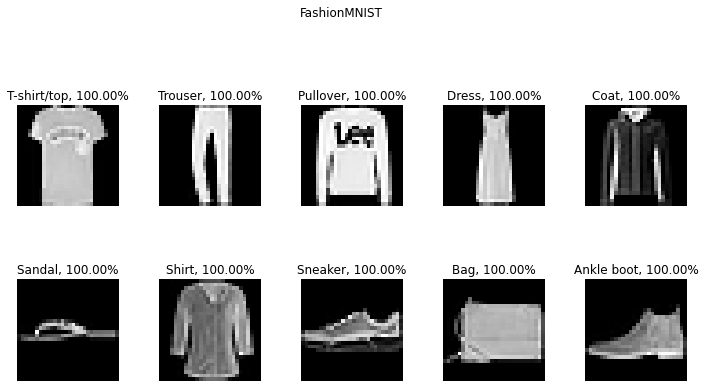

In [ ]:
X, y = next(iter(test_loader))

idx = [np.where(y==label)[0][0] for label in set(y.numpy())]

X, y = X[idx], y[idx]

y_pred = y
probs = np.ones_like(y)*100

plot_res(simple=True, title='FashionMNIST')

**Вопрос:** Какие классы лего перепутать?

Напишем функции для обучения и инференса нашей модели.

In [ ]:
def train(model, train_loader, criterion, optimizer):
    epoch_loss = 0.
    model.train()

    N = sum(len(y) for _, y in train_loader)

    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_train = epoch_loss / N
    return loss_train


def evaluate(model, test_loader):
    epoch_acc = 0.
    model.eval()

    N = sum(len(y) for _, y in test_loader)

    with torch.no_grad():
      for X, y in test_loader:
          X = X.to(device)
          y = y.to(device)
          y_pred = model(X)
          epoch_acc += (y_pred.argmax(1) == y).float().sum().item()
        
    acc_test = epoch_acc / N
    return acc_test

Реализуем простую сверточную сеть:

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 8, 5, stride=2), # 12х12
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, 5, stride=2), # 4x4
            nn.LeakyReLU(), nn.Flatten(1,-1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*16, 16), nn.LeakyReLU(),
            nn.Linear(16, n_classes)
        )

    def forward(self, x):
        hidden = self.features(x)
        logits = self.classifier(hidden)
        return logits

Посчитаем количество параметров:

In [ ]:
n_p = sum(p.numel() for p in SimpleCNN(in_channels=1).parameters())
print(f'Number of parameters: {n_p}')

Number of parameters: 7706


**Вопрос:** почему стоит проверять количество параметров для кастомных архитектур?

Обучим ее на всем датасете.

In [ ]:
torch.manual_seed(42)

model = SimpleCNN(in_channels=1)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [7, 12], gamma=0.1)

accs_train = []
accs_test = []
num_epochs = 15

pbar = tqdm(range(num_epochs), position=0, leave=True)
for epoch in pbar:
    loss_train = train(model, train_loader, criterion, optimizer)
    acc_test = evaluate(model, test_loader)
    accs_test.append(acc_test)
    scheduler.step()
    pbar.set_postfix({'acc_test': f'{acc_test*100:.2f}'})

100%|██████████| 15/15 [04:25<00:00, 17.67s/it, acc_test=88.05]


Посмотрим на результат:

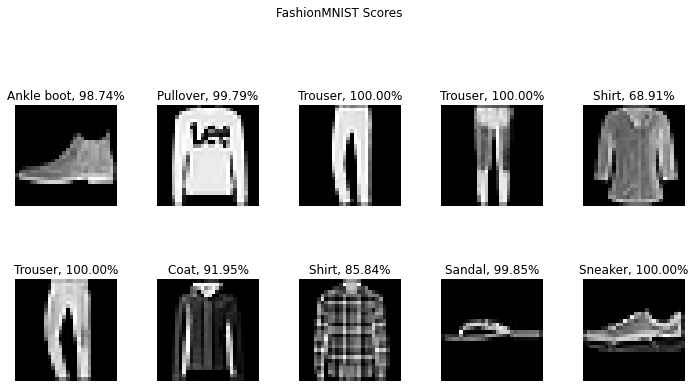

In [ ]:
X, y = next(iter(test_loader))

p_pred = F.softmax(model(X.to(device)))
y_pred = p_pred.argmax(1)
probs = p_pred[range(len(y_pred)), y_pred]*100

plot_res(simple=True, title='FashionMNIST Scores')

Возьмем теперь MNIST датасет и посмотрим, что выдает на нем наша модель:

In [ ]:
mnist_data = torchvision.datasets.MNIST('.', download=True, train=False, transform=test_transform)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=10,
                                          shuffle=False, num_workers=1)

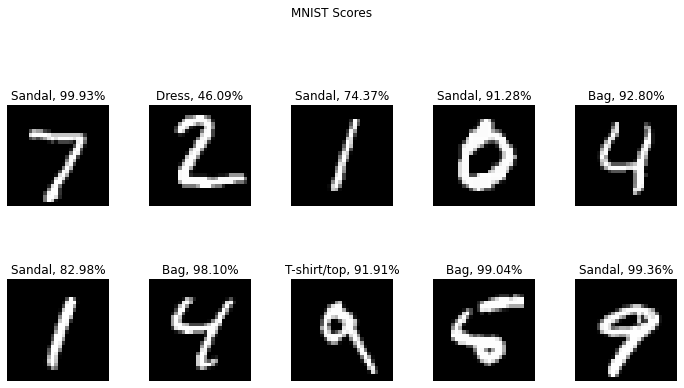

In [ ]:
X, y = next(iter(mnist_loader))

p_pred = F.softmax(model(X.to(device)))
y_pred = p_pred.argmax(1)
probs = p_pred[range(len(y_pred)), y_pred]*100

plot_res(simple=True, title='MNIST Scores')

Наша модель дает большие вероятности принадлежности к классам. Хотя это совсем не одежда!

**Вопрос:** Почему? Можете объяснить на примере какой-нибудь картинки.

## MC-Dropout

Добавим теперь Dropout слой и обучим нашу модель заново.

In [ ]:
torch.manual_seed(7)

model = SimpleCNN(in_channels=1)
model.classifier = nn.Sequential(nn.Dropout(0.5), model.classifier)
model.to(device)

criterion = nn.CrossEntropyLoss()
l2_reg = 1e-2 * (1 - 0.5) / len(train_data)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=l2_reg)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [7, 12], gamma=0.1)

accs_train = []
accs_test = []
num_epochs = 15

pbar = tqdm(range(num_epochs), position=0, leave=True)
for epoch in pbar:
    loss_train = train(model, train_loader, criterion, optimizer)
    acc_test = evaluate(model, test_loader)
    accs_test.append(acc_test)
    scheduler.step()
    pbar.set_postfix({'acc_test': f'{acc_test*100:.2f}'})

100%|██████████| 15/15 [04:21<00:00, 17.43s/it, acc_test=86.89]


 **Вопрос:** Почему скор стал меньше?

Добавим функцию для сбора статистики предсказаний, основанных на сэмплировании с помощью Dropout:

In [ ]:
def dropout_stat(model, X, num_samples=10):
  model.train()
  preds = []
  with torch.no_grad():
    for _ in range(num_samples):
      y = F.softmax(model(X), 1)
      preds.append(y)
  preds = torch.cat(preds).view(num_samples, -1, 10)
  q1 = preds.quantile(0.05, dim=0)
  q2 = preds.quantile(0.95, dim=0)
  mean = preds.mean(dim=0)
  std = preds.std(dim=0)
  return q1, q2, mean, std


Посмотрим, что теперь у нас вышло:

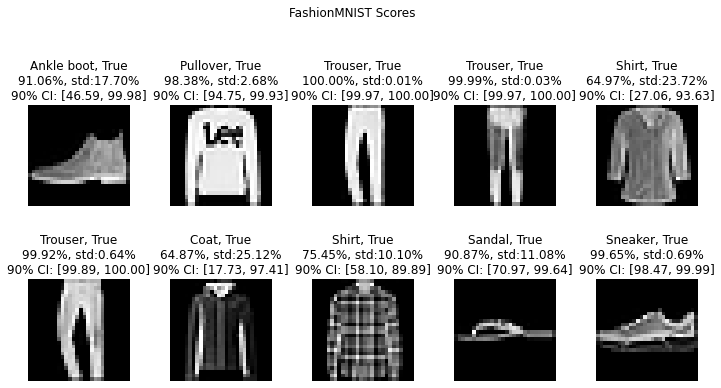

In [ ]:
X, y = next(iter(test_loader))

q1, q2, p_pred, std = dropout_stat(model, X.to(device), num_samples=100)

y_pred = p_pred.argmax(1)
probs = p_pred[range(len(y_pred)), y_pred]*100
std = std[range(len(y_pred)), y_pred]*100
q1 = q1[range(len(y_pred)), y_pred]*100
q2 = q2[range(len(y_pred)), y_pred]*100

plot_res(simple=False, title='FashionMNIST Scores')

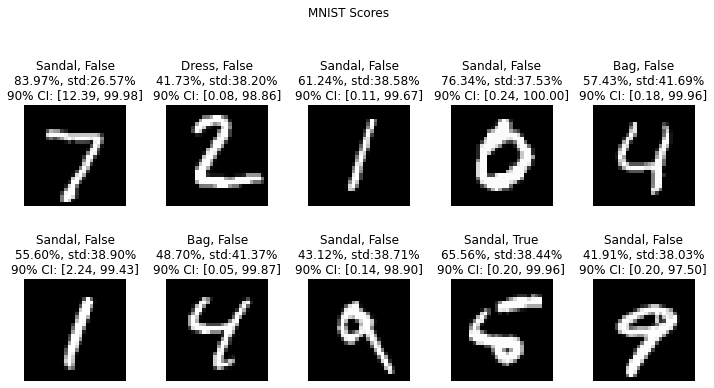

In [ ]:
X, y = next(iter(mnist_loader))

q1, q2, p_pred, std = dropout_stat(model, X.to(device), num_samples=100)

y_pred = p_pred.argmax(1)
probs = p_pred[range(len(y_pred)), y_pred]*100
std = std[range(len(y_pred)), y_pred]*100
q1 = q1[range(len(y_pred)), y_pred]*100
q2 = q2[range(len(y_pred)), y_pred]*100

plot_res(simple=False, title='MNIST Scores')

**Вопрос**: Хорошая ли получилась оценка неопределенности?

Теперь мы можем учитывать неопределенность модели при принятии решений.

**Вопрос:** Почему называется MC?

## Bayesian Neural Network

Другой способ получения неопределенности модели это задание случайных весов.

Вспонимаем Pyro :)

In [ ]:
!pip install pyro-ppl

In [ ]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

from pyro.nn.module import to_pyro_module_

Переобпределим .forward

In [ ]:
def pyro_forward(self, x, y=None):
    logits = self._forward(x)
    probs = F.softmax(logits, dim=1)

    with pyro.plate("data", x.shape[0]):
        # ...do conditionally independent stuff ...
        obs = pyro.sample("class", dist.Categorical(probs).to_event(1), obs=y)
    return probs

model = SimpleCNN()
to_pyro_module_(model)
model._forward = model.forward.__get__(model, SimpleCNN)
model.forward = pyro_forward.__get__(model, SimpleCNN)

Добавим априорные распределения:

In [ ]:
from pyro.nn import PyroSample

def add_priors(model):
    for m in model.modules():

        if isinstance(m, nn.Conv2d): 
        
          for name, value in list(m.named_parameters(recurse=False)):
              mean = torch.tensor(0.).to(device)
              sigma = torch.tensor(1.).to(device)
              setattr(m, name, PyroSample(dist.Normal(mean, sigma).expand(value.shape).to_event(value.dim())))

Добавим апострериорное распределение:

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal

guide = AutoDiagonalNormal(model)

Реализуем функции обучения и инференса:

In [ ]:
def pyro_train(svi, train_loader):
    epoch_loss = 0.

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        epoch_loss += svi.step(X, y)

    loss_train = epoch_loss / len(train_loader.dataset)
    return loss_train

from pyro.infer import Predictive

def pyro_evaluate(svi, test_loader,  num_samples=10):
    epoch_acc = 0.

    predictive = Predictive(svi.model, guide=svi.guide, num_samples=num_samples,
                            return_sites=["_RETURN"])

    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        samples = predictive(X)
        y_mean = samples['_RETURN'].mean(0)
        
        epoch_acc += (y_mean.argmax(1) == y).float().sum()
        
    acc_test = epoch_acc / len(test_loader.dataset)
    return acc_test

Обучим нашу модель:

In [ ]:
from pyro.infer import SVI, Trace_ELBO


pyro.clear_param_store()

torch.manual_seed(42)
pyro.set_rng_seed(42)

model = SimpleCNN()
to_pyro_module_(model)
model._forward = model.forward.__get__(model, SimpleCNN)
model.forward = pyro_forward.__get__(model, SimpleCNN)
add_priors(model)

guide = AutoDiagonalNormal(model)

model.to(device)
guide.to(device)

adam_parameters = {"lr": 0.01}
optimizer = torch.optim.Adam
scheduler = pyro.optim.MultiStepLR({'optimizer': optimizer, 'optim_args': adam_parameters, 'gamma': 0.1, 'milestones': [7, 12]})

svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=2))

train_elbo = []
test_accs = []
num_epochs = 15
pbar = tqdm(range(num_epochs), position=0, leave=True)
for epoch in pbar:
    elbo = pyro_train(svi, train_loader)
    train_elbo.append(-elbo)
    acc = pyro_evaluate(svi, test_loader, num_samples=10)
    test_accs.append(acc)
    scheduler.step()
    pbar.set_postfix({'acc_test': f'{acc*100:.2f}'})




100%|██████████| 15/15 [04:10<00:00, 16.68s/it, acc_test=86.33]


Соберем статистику предсказаний:

In [ ]:
from pyro.infer import Predictive

def pyro_stat(model, X, guide, num_samples=10):
    predictive = Predictive(model, guide=guide, num_samples=num_samples,
                            return_sites=["_RETURN"])
    samples = predictive(X)

    preds = samples['_RETURN']
    q1 = preds.quantile(0.05, dim=0)
    q2 = preds.quantile(0.95, dim=0)
    mean = preds.mean(dim=0)
    std = preds.std(dim=0)
    return q1, q2, mean, std

Посмотрим, что у нас вышло:

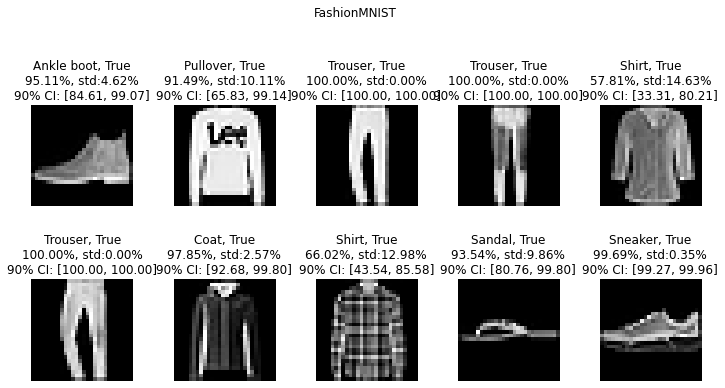

In [ ]:
X, y = next(iter(test_loader))

q1, q2, p_pred, std = pyro_stat(model, X.to(device), guide, num_samples=100)

y_pred = p_pred.argmax(1)
probs = p_pred[range(len(y_pred)), y_pred]*100
std = std[range(len(y_pred)), y_pred]*100
q1 = q1[range(len(y_pred)), y_pred]*100
q2 = q2[range(len(y_pred)), y_pred]*100

plot_res(simple=False, title='FashionMNIST')

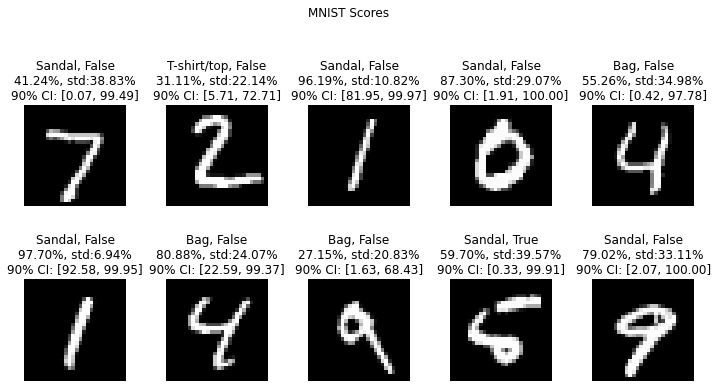

In [ ]:
X, y = next(iter(mnist_loader))

q1, q2, p_pred, std = pyro_stat(model, X.to(device), guide, num_samples=1000)

y_pred = p_pred.argmax(1)
probs = p_pred[range(len(y_pred)), y_pred]*100
std = std[range(len(y_pred)), y_pred]*100
q1 = q1[range(len(y_pred)), y_pred]*100
q2 = q2[range(len(y_pred)), y_pred]*100

plot_res(simple=False, title='MNIST Scores')

Все хорошо, неопределенность получаем. Можем ее дальше использовать.

## Simple Ensemble

Построим теперь классический ансамбль сетей.

**Вопрос:** В чем недостаток подхода?

In [ ]:
from sklearn.model_selection import train_test_split

part_idx, _ = train_test_split(range(len(train_data)), train_size=5000, random_state=0,
                               stratify=train_data.targets)

part_sampler = torch.utils.data.SubsetRandomSampler(part_idx)

part_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                          sampler=part_sampler, num_workers=1)

Обучим ансамбль размера 10:

In [ ]:
torch.manual_seed(42)
models = []

for _ in range(10):

    model = SimpleCNN(in_channels=1)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 15], gamma=0.1)

    accs_train = []
    accs_test = []
    num_epochs = 20

    pbar = tqdm(range(num_epochs), position=0, leave=True)
    for epoch in pbar:
        loss_train = train(model, part_loader, criterion, optimizer)
        scheduler.step()

    models.append(model)

100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


Посмотрим средний скор элементов ансамбля:

In [ ]:
accs = [evaluate(model, test_loader) for model in models]
np.mean(accs)

0.82835

А какой будет скор, если мы усредним предсказания?

In [ ]:
acc = 0
for X, y in test_loader:
  X = X.to(device)
  y = y.to(device)
  probs = 0
  for model in models:
    probs += F.softmax(model(X), 1)
  y_pred = probs.argmax(1)
  acc += (y == y_pred).float().sum().cpu().item()
    
print('Test accuracy: ', acc / len(test_loader.dataset))

Test accuracy:  0.8474


Видим, что скор увеличивается.

Как и положено ансамблям.

### EOF